In [1]:
import networkx
import torch
import numpy as np
import pandas as pd
from sklearn.metrics import *
from torch_geometric.loader import NeighborSampler, NeighborLoader
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GATConv, ResGatedGraphConv, GATv2Conv, SAGEConv, GENConv, DeepGCNLayer, PairNorm, GINConv
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import torch.nn.functional as F
from imblearn.under_sampling import RandomUnderSampler
pd.options.mode.use_inf_as_na = True
from collections import Counter
from sklearn.feature_selection import SelectFromModel
import torch.nn as nn
import time
import pickle
from torch.nn import LayerNorm, Linear, ReLU
from torch_scatter import scatter
from tqdm import tqdm
from torch_geometric.loader import RandomNodeSampler
import math
import copy
from sklearn.metrics import f1_score
from torch.optim import lr_scheduler
from sklearn.manifold import TSNE

In [2]:
import warnings
# action参数可以设置为ignore，一位一次也不喜爱你是，once表示为只显示一次
warnings.filterwarnings(action='ignore')

In [3]:
np.random.seed(2022)
torch.manual_seed(2022)

In [4]:
class Transition_layer(torch.nn.Module):
    def __init__(self, act, norm, lin):
        super().__init__()
        self.act = act
        self.norm = norm
        self.lin = lin
    def forward(self, x):
        x = self.norm(x)
        x = self.act(x)
        x = self.lin(x)
        return x
        
class DenseGAT(torch.nn.Module):
    def __init__(self, in_channels, num_class, num_layers=6, num_blocks=3, growth_rate=10, theta=0.5):
        super().__init__()
        self.num_layers = num_layers
        self.blocks = num_blocks
        self.theta = theta
        self.growth_rate = growth_rate
        self.base_rate = growth_rate
        self.in_channels = in_channels
        self.out_channels = num_class
        self.linear_layers = torch.nn.ModuleList()
        self.transition_layers = torch.nn.ModuleList()
        self.block_layers = torch.nn.ModuleList()
        self.node_encoder = Linear(in_channels, in_channels)
        self.linear_layers.append(self.node_encoder)
        
        for i in range(self.blocks):
            # block
            layers = torch.nn.ModuleList()
            # 2^(i - 1) * k0
            self.growth_rate = int(math.pow(2, i) * self.base_rate)
            print(self.growth_rate)
            for j in range(1, self.num_layers + 1):
                conv = GATv2Conv(in_channels + (j - 1) * self.growth_rate, self.growth_rate, aggr='max') 
                norm = LayerNorm(self.growth_rate)
                act = ReLU()
                layer = DeepGCNLayer(conv, norm, act, block='dense')
                layers.append(layer)
            self.block_layers.append(layers)
            
            # transition
            hidden_channels = in_channels +  self.num_layers * self.growth_rate
            out_channels = int(hidden_channels * self.theta)
            transition_norm = LayerNorm(hidden_channels, elementwise_affine=True)
            transition_act = ReLU()
            transition_lin = Linear(hidden_channels, out_channels)
            transitionLayer = Transition_layer(transition_act, transition_norm, transition_lin)
            self.transition_layers.append(transitionLayer)
            in_channels = copy.copy(out_channels)
        
        self.lin_last = Linear(in_channels, self.out_channels)
        self.linear_layers.append(self.lin_last)
        
    def forward(self, x, edge_index):
#         x = self.linear_layers[0](x)
        for i in range(self.blocks):
            # block layer
            for layer in self.block_layers[i]:
                x = layer(x, edge_index)
            # transition layer
            x = self.transition_layers[i](x)
        x = self.linear_layers[-1](x)
        return x

In [5]:
def train():
    total_loss = total_correct = total_examples = 0
    start_time = time.time()
    for batch in train_loader:
        batch = batch.to(device)
        y = batch.y[:batch.batch_size]
        optimizer.zero_grad()
        y_hat = model(batch.x.to(device), batch.edge_index.to(device))[:batch.batch_size]
        loss = F.cross_entropy(y_hat, y)
        loss.backward()
        optimizer.step()
#         scheduler1.step()
        total_loss += float(loss) * batch.batch_size
        total_correct += int((y_hat.argmax(dim=-1) == y).sum())
        total_examples += batch.batch_size
    end_time = time.time()  
    
    return total_loss / total_examples, total_correct / total_examples

def inferrence(model, subgraph_loader):
    total_loss = total_correct = total_examples = 0
    xs = []
    y = []
    pbar = tqdm(total=len(subgraph_loader))
    for batch in subgraph_loader:
        y_hat = model(batch.x, batch.edge_index.to(device))[:batch.batch_size]
        xs.append(y_hat.cpu())
        y_true = batch.y[:batch.batch_size]
        y.append(y_true.cpu())
        pbar.update(1)
    pbar.close()
    y_hat = torch.cat(xs, 0)
    y_hat = y_hat.detach().numpy()
    y_hat = np.argmax(y_hat, -1)
    y = torch.cat(y, 0)
    print(y_hat)
    print(y)
    cr1 = classification_report(y, y_hat,digits=2)
    cf = confusion_matrix(y, y_hat)
    print(cr1)
    print(cf)

def get_metrics(y_true, y_pred):
    cr = classification_report(y_true, y_pred, digits=4)
    cm = confusion_matrix(y_true, y_pred)
    print(cr)
    print(cm)

In [6]:
from torch_geometric.utils import *

In [7]:
train_data = torch.load('/home/xiaoyujie/densegat/mydata/unsw15_train_lg')

In [8]:
test_data = torch.load('/home/xiaoyujie/densegat/mydata/unsw15_test_lg')

In [9]:
all_data = torch.load('/home/xiaoyujie/densegat/mydata/unswnb15_alldata')

In [10]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',np.unique(train_data.y.numpy()),train_data.y.numpy())
print(class_weights)
class_weights = torch.FloatTensor(class_weights).to(device)

[1.14480248e-01 5.70476418e+00 1.81610242e+01 1.55330760e+01
 1.17877832e+00 1.68075848e+02 1.04760375e+01 1.46189712e+03
 1.09073376e+02 9.48663399e+01]


NameError: name 'device' is not defined

In [9]:
train_data, test_data

(Data(x=[2032037, 41], edge_index=[2, 15968136], y=[2032037], num_nodes=2032037),
 Data(x=[508010, 41], edge_index=[2, 1025396], y=[508010], num_nodes=508010))

In [11]:
train_data, test_data, all_data

(Data(x=[2032037, 41], edge_index=[2, 15968136], y=[2032037], num_nodes=2032037),
 Data(x=[508010, 41], edge_index=[2, 1025396], y=[508010], num_nodes=508010),
 Data(x=[2540047, 41], edge_index=[2, 25083017], y=[2540047], num_nodes=2540047, train_mask=[2032037], test_mask=[508010]))

In [12]:
# 是否加自环

In [13]:
train_data.edge_index = add_self_loops(train_data.edge_index)[0]
test_data.edge_index = add_self_loops(test_data.edge_index)[0]

In [14]:
train_data, test_data, all_data

(Data(x=[2032037, 41], edge_index=[2, 18000173], y=[2032037], num_nodes=2032037),
 Data(x=[508010, 41], edge_index=[2, 1533393], y=[508010], num_nodes=508010),
 Data(x=[2540047, 41], edge_index=[2, 25083017], y=[2540047], num_nodes=2540047, train_mask=[2032037], test_mask=[508010]))

In [15]:
# 二分类

In [155]:
train_label = train_data.y.numpy()
test_label = test_data.y.numpy()
train_label[train_label != 0] = 1
test_label[test_label != 0] = 1
train_data.y = torch.LongTensor(train_label)
test_data.y = torch.LongTensor(test_label)

In [16]:
train_num_nodes = torch.arange(len(train_data.y))
test_num_nodes = torch.arange(len(test_data.y))

In [17]:
train_data.contains_isolated_nodes()

False

In [18]:
train_data = train_data.to('cpu')
test_data = test_data.to('cpu')

In [65]:
node_num_per_k = 10
depth = 3

In [66]:
hop = [node_num_per_k] * depth
train_loader = NeighborLoader(train_data, input_nodes = train_num_nodes, num_neighbors=hop, batch_size=1024, shuffle=True)

In [67]:
next(iter(train_loader))

Data(x=[2519, 41], edge_index=[2, 4071], y=[2519], num_nodes=2519, batch_size=1024)

In [68]:
subgraph_loader = NeighborLoader(test_data, input_nodes=test_num_nodes,num_neighbors=hop, batch_size=1024, shuffle=False)

In [69]:
in_channels = train_data.x.size(-1)
num_class = 10
model = DenseGAT(in_channels=in_channels, num_class=num_class, 
                 num_layers=3, num_blocks=1, growth_rate=10, theta=0.2)
loss_all = []

10


In [70]:
sum(p.numel() for p in model.parameters())

6262

In [71]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [72]:
device = 'cuda:3'
model = model.to(device)

In [ ]:
model.train()
epochs = 500
for i in range(1, 1 + epochs):
    start_time = time.time()
    loss, acc = train()
    end_time = time.time()
    if i % 10 == 0:
        optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
    if i % 5:
        torch.save(model.state_dict(), 'unsw_epoch_' + str(i))
    print('epoch: {:04d}'.format(i),
          'loss_train: {:.4f}'.format(loss),
          'acc_train: {:.4f}'.format(acc),
          'time: {:.4f}s'.format(end_time - start_time))
    loss_all.append(loss)

epoch: 0001 loss_train: 0.0783 acc_train: 0.9709 time: 25.4631s
epoch: 0002 loss_train: 0.0646 acc_train: 0.9746 time: 28.1804s
epoch: 0003 loss_train: 0.0623 acc_train: 0.9752 time: 26.9731s
epoch: 0004 loss_train: 0.0611 acc_train: 0.9756 time: 24.9103s
epoch: 0005 loss_train: 0.0603 acc_train: 0.9758 time: 26.2494s
epoch: 0006 loss_train: 0.0597 acc_train: 0.9760 time: 24.5251s
epoch: 0007 loss_train: 0.0590 acc_train: 0.9764 time: 24.9632s
epoch: 0008 loss_train: 0.0584 acc_train: 0.9766 time: 30.2309s
epoch: 0009 loss_train: 0.0582 acc_train: 0.9767 time: 29.3853s
epoch: 0010 loss_train: 0.0579 acc_train: 0.9768 time: 33.8158s
epoch: 0011 loss_train: 0.0567 acc_train: 0.9775 time: 34.0565s
epoch: 0012 loss_train: 0.0561 acc_train: 0.9777 time: 34.5833s
epoch: 0013 loss_train: 0.0558 acc_train: 0.9778 time: 33.2635s
epoch: 0014 loss_train: 0.0556 acc_train: 0.9779 time: 34.5225s
epoch: 0015 loss_train: 0.0555 acc_train: 0.9779 time: 33.9208s
epoch: 0016 loss_train: 0.0554 acc_train

In [30]:
device = 'cpu'
model = model.to(device)

In [31]:
y_hat = model(test_data.x.to(device), test_data.edge_index.to(device))
y_hat = y_hat.detach().numpy()

In [32]:
y_hat = np.argmax(y_hat, -1)
test_y = test_data.y.numpy()

In [33]:
get_metrics(test_y, y_hat)

              precision    recall  f1-score   support

           0     0.9932    0.9966    0.9949    443753
           1     0.5796    0.8476    0.6884      8905
           2     0.6081    0.4403    0.5108      2798
           3     0.3396    0.0660    0.1106      3271
           4     0.9948    0.9806    0.9876     43096
           5     0.1414    0.5397    0.2241       302
           6     0.5555    0.3848    0.4547      4849
           7     0.0000    0.0000    0.0000        35
           8     0.3333    0.0172    0.0327       466
           9     0.3478    0.0150    0.0287       535

    accuracy                         0.9755    508010
   macro avg     0.4893    0.4288    0.4032    508010
weighted avg     0.9737    0.9755    0.9729    508010

[[442240    438    148      4     14     31    876      0      0      2]
 [   271   7548    388    216    119     64    289      0      5      5]
 [   124    535   1232     40      5    829     33      0      0      0]
 [   123   2649     49

In [224]:
get_metrics(test_y, y_hat)

              precision    recall  f1-score   support

           0     0.9988    0.9865    0.9926    443753
           1     0.9142    0.9920    0.9515     64257

    accuracy                         0.9872    508010
   macro avg     0.9565    0.9893    0.9721    508010
weighted avg     0.9881    0.9872    0.9874    508010

[[437772   5981]
 [   511  63746]]


In [192]:
get_metrics(test_y, y_hat)

              precision    recall  f1-score   support

           0     0.9951    0.9956    0.9953    443753
           1     0.9692    0.9659    0.9676     64257

    accuracy                         0.9918    508010
   macro avg     0.9821    0.9807    0.9814    508010
weighted avg     0.9918    0.9918    0.9918    508010

[[441781   1972]
 [  2189  62068]]


In [183]:
get_metrics(test_y, y_hat)

              precision    recall  f1-score   support

           0     0.9951    0.9955    0.9953    443753
           1     0.9689    0.9661    0.9675     64257

    accuracy                         0.9918    508010
   macro avg     0.9820    0.9808    0.9814    508010
weighted avg     0.9918    0.9918    0.9918    508010

[[441761   1992]
 [  2180  62077]]


In [154]:
get_metrics(test_y, y_hat)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    443753
           1       0.57      0.90      0.70      8905
           2       0.89      0.63      0.74      2798
           3       0.26      0.02      0.04      3271
           4       0.99      0.98      0.99     43096
           5       0.33      0.35      0.34       302
           6       0.59      0.27      0.37      4849
           7       0.00      0.00      0.00        35
           8       0.00      0.00      0.00       466
           9       0.57      0.01      0.01       535

    accuracy                           0.98    508010
   macro avg       0.52      0.42      0.42    508010
weighted avg       0.97      0.98      0.97    508010

[[442564    333     54     24     57     71    649      0      0      1]
 [   487   8050     72     78     62     34    122      0      0      0]
 [   250    695   1764     29      3      4     53      0      0      0]
 [   222   2892      6

In [124]:
get_metrics(test_y, y_hat)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    443753
           1       0.58      0.86      0.70      8905
           2       0.80      0.68      0.73      2798
           3       0.38      0.03      0.05      3271
           4       0.99      0.98      0.99     43096
           5       0.23      0.54      0.33       302
           6       0.48      0.38      0.43      4849
           7       0.06      0.03      0.04        35
           8       0.37      0.03      0.05       466
           9       0.62      0.01      0.03       535

    accuracy                           0.98    508010
   macro avg       0.55      0.45      0.43    508010
weighted avg       0.97      0.98      0.97    508010

[[441998    214     66      2     31    188   1242     10      1      1]
 [   282   7679    258     84    115     91    388      1      6      1]
 [   290    530   1908     18      4     14     34      0      0      0]
 [    70   2799     31

In [81]:
get_metrics(test_y, y_hat)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    443753
           1       0.58      0.88      0.70      8905
           2       0.87      0.62      0.72      2798
           3       0.35      0.04      0.07      3271
           4       0.99      0.98      0.99     43096
           5       0.38      0.61      0.46       302
           6       0.50      0.48      0.49      4849
           7       0.38      0.09      0.14        35
           8       0.50      0.04      0.07       466
           9       0.36      0.01      0.03       535

    accuracy                           0.98    508010
   macro avg       0.59      0.47      0.47    508010
weighted avg       0.98      0.98      0.97    508010

[[441685    314     28     29     22     81   1587      0      0      7]
 [   286   7817    171     89    153     64    311      3      7      4]
 [   181    780   1731     16      8     34     46      0      2      0]
 [   105   2780     19

In [35]:
get_metrics(test_y, y_hat)

              precision    recall  f1-score        support
0              0.993963  0.994698  0.994330  443753.000000
1              0.583884  0.784391  0.669446    8905.000000
2              0.803059  0.600429  0.687117    2798.000000
3              0.323759  0.279120  0.299787    3271.000000
4              0.993939  0.981762  0.987813   43096.000000
5              0.518349  0.374172  0.434615     302.000000
6              0.479696  0.416581  0.445916    4849.000000
7              0.000000  0.000000  0.000000      35.000000
8              0.000000  0.000000  0.000000     466.000000
9              0.175439  0.018692  0.033784     535.000000
accuracy       0.975239  0.975239  0.975239       0.975239
macro avg      0.487209  0.444984  0.455281  508010.000000
weighted avg   0.974372  0.975239  0.974358  508010.000000
[[441400    647     22      6     24     19   1592      0      0     43]
 [   168   6985    247   1065    116     29    292      0      0      3]
 [   218    646   1680    15

In [40]:
get_metrics(test_y, y_hat)

              precision    recall  f1-score        support
0              0.991775  0.998319  0.995036  443753.000000
1              0.748031  0.565413  0.644027    8905.000000
2              0.825980  0.722659  0.770873    2798.000000
3              0.335417  0.705289  0.454626    3271.000000
4              0.994107  0.982435  0.988236   43096.000000
5              0.376499  0.519868  0.436718     302.000000
6              0.610200  0.276346  0.380412    4849.000000
7              0.000000  0.000000  0.000000      35.000000
8              0.434783  0.042918  0.078125     466.000000
9              0.500000  0.020561  0.039497     535.000000
accuracy       0.976827  0.976827  0.976827       0.976827
macro avg      0.581679  0.483381  0.478755  508010.000000
weighted avg   0.977456  0.976827  0.975478  508010.000000
[[443007    118     39     28     27     77    451      0      0      6]
 [   354   5035    275   2847    118     73    189      1     10      3]
 [   190    137   2022    41

In [34]:
get_metrics(test_y, y_hat)

              precision    recall  f1-score        support
0              0.993368  0.996397  0.994880  443753.000000
1              0.571617  0.876137  0.691851    8905.000000
2              0.807936  0.684060  0.740855    2798.000000
3              0.372718  0.106084  0.165159    3271.000000
4              0.994865  0.980045  0.987399   43096.000000
5              0.531073  0.311258  0.392484     302.000000
6              0.524316  0.355743  0.423885    4849.000000
7              0.000000  0.000000  0.000000      35.000000
8              0.000000  0.000000  0.000000     466.000000
9              0.323529  0.020561  0.038664     535.000000
accuracy       0.976916  0.976916  0.976916       0.976916
macro avg      0.511942  0.433028  0.443518  508010.000000
weighted avg   0.974647  0.976916  0.974395  508010.000000
[[442154    287    209      9     19     20   1042      0      0     13]
 [   299   7802     61    359    110     19    246      0      0      9]
 [    69    730   1914     5

In [138]:
get_metrics(test_y, y_hat)

              precision    recall  f1-score       support
0              0.999213  0.987000  0.993069  45000.000000
1              0.635344  0.670160  0.652288   6679.000000
2              0.506646  0.308866  0.383773   2098.000000
3              0.350467  0.030575  0.056243   2453.000000
4              0.994533  0.979333  0.986875  32322.000000
5              0.415842  0.185022  0.256098    227.000000
6              0.374676  0.834754  0.517206   3637.000000
7              0.333333  0.153846  0.210526     26.000000
8              0.500000  0.017192  0.033241    349.000000
9              0.442953  0.164179  0.239564    402.000000
accuracy       0.905883  0.905883  0.905883      0.905883
macro avg      0.555301  0.433093  0.432888  93193.000000
weighted avg   0.913098  0.905883  0.900692  93193.000000
[[44415    55    31     2     1     0   459     0     0    37]
 [   15  4476   284    66    85    25  1692     3     6    27]
 [    2   188   648    30    18     3  1205     0     0     4]

In [96]:
get_metrics(test_y, y_hat)

              precision    recall  f1-score       support
0              0.993602  0.987044  0.990312  45000.000000
1              0.693796  0.574337  0.628440   6679.000000
2              0.250423  0.493804  0.332318   2098.000000
3              0.331714  0.194863  0.245506   2453.000000
4              0.994162  0.979952  0.987006  32322.000000
5              0.328467  0.198238  0.247253    227.000000
6              0.548369  0.794886  0.649007   3637.000000
7              0.000000  0.000000  0.000000     26.000000
8              0.000000  0.000000  0.000000    349.000000
9              0.407080  0.114428  0.178641    402.000000
accuracy       0.905894  0.905894  0.905894      0.905894
macro avg      0.454761  0.433755  0.425848  93193.000000
weighted avg   0.912633  0.905894  0.906197  93193.000000
[[44417    44     1     2     3     0   498     0     0    35]
 [   87  3836  1291   588   114    21   722     0     0    20]
 [   15   189  1036    71     7     0   776     0     0     4]

In [61]:
get_metrics(test_y, y_hat)

              precision    recall  f1-score       support
0              0.986245  0.987844  0.987044  45000.000000
1              0.768386  0.481809  0.592252   6679.000000
2              0.307569  0.275024  0.290388   2098.000000
3              0.309278  0.012230  0.023529   2453.000000
4              0.883708  0.983912  0.931122  32322.000000
5              0.228155  0.207048  0.217090    227.000000
6              0.489002  0.764091  0.596352   3637.000000
7              0.333333  0.038462  0.068966     26.000000
8              0.000000  0.000000  0.000000    349.000000
9              0.480519  0.092040  0.154489    402.000000
accuracy       0.890024  0.890024  0.890024      0.890024
macro avg      0.478620  0.384246  0.386123  93193.000000
weighted avg   0.874662  0.890024  0.873643  93193.000000
[[44453    50    20     1    42     1   416     0     0    17]
 [  194  3218   537    44  1444    47  1184     0     0    11]
 [   67    50   577     2   768    41   590     0     0     3]

In [29]:
get_metrics(test_y, y_hat)

              precision    recall  f1-score       support
0              0.999685  0.986778  0.993189  45000.000000
1              0.987801  0.999710  0.993720  48193.000000
accuracy       0.993465  0.993465  0.993465      0.993465
macro avg      0.993743  0.993244  0.993454  93193.000000
weighted avg   0.993539  0.993465  0.993464  93193.000000
[[44405   595]
 [   14 48179]]


In [111]:
from tqdm import tqdm

In [112]:
subgraph_loader2 = NeighborLoader(copy.copy(all_data), input_nodes=None,num_neighbors=[-1], batch_size=1024, shuffle=False)
subgraph_loader2.data.num_nodes = all_data.num_nodes
subgraph_loader2.data.n_id = torch.arange(all_data.num_nodes)

In [113]:
def inferrence2(model, subgraph_loader):
    pbar = tqdm(total=len(subgraph_loader))
    for i, batch in enumerate(subgraph_loader):
        batch = batch.to(device)
        y_hat = model(batch.x.to(device), batch.edge_index.to(device))[:batch.batch_size]
        np.save('unsw_yhat/y_hat_batch' + str(i), y_hat.detach().numpy())
        pbar.update(1)
    pbar.close()

In [119]:
def test(data, loader):
    xs = []
    for i in range(len(loader)):
        y_hat = np.load('unsw_yhat/y_hat_batch' + str(i) + '.npy')
        xs.append(y_hat)
    y_hat = np.concatenate(xs, 0)
    y_hat = np.argmax(y_hat, -1)
    y = data.y.to(device)
    test_mask = data.test_mask 
    pr = precision_score(y[test_mask], y_hat[test_mask], average='weighted')
    cr1 = classification_report(y[test_mask], y_hat[test_mask], digits=4)
    cf = confusion_matrix(y[test_mask], y_hat[test_mask])
    print("测试集结果：")
    print(cr1)
    print(cf)
    
    train_mask = data.train_mask
    pr = precision_score(y[train_mask], y_hat[train_mask], average='weighted')
    cr1 = classification_report(y[train_mask], y_hat[train_mask], digits=4)
    cf = confusion_matrix(y[train_mask], y_hat[train_mask])
    print("训练集结果：")
    print(cr1)
    print(cf)


In [115]:
device = 'cpu'

In [116]:
model = model.to(device)

In [117]:
inferrence2(model, subgraph_loader2)

100%|██████████| 2481/2481 [01:48<00:00, 22.92it/s]


In [120]:
test(all_data, subgraph_loader2)
# {
#     'Normal': 0,
#      'Exploits': 1,
#      'Reconnaissance': 2,
#      'DoS': 3,
#      'Generic': 4,
#      'Shellcode':5,
#      'Fuzzers': 6,
#      'Worms': 7,
#      'Backdoors': 8,
#      'Analysis': 9
# }

测试集结果：
              precision    recall  f1-score   support

           0     0.9937    0.9967    0.9952    443753
           1     0.5813    0.8883    0.7027      8905
           2     0.8174    0.7616    0.7885      2798
           3     0.3939    0.0358    0.0656      3271
           4     0.9940    0.9811    0.9875     43096
           5     0.5789    0.4371    0.4981       302
           6     0.5733    0.4209    0.4854      4849
           7     0.0000    0.0000    0.0000        35
           8     0.4000    0.0215    0.0407       466
           9     0.5000    0.0150    0.0290       535

    accuracy                         0.9782    508010
   macro avg     0.5833    0.4558    0.4593    508010
weighted avg     0.9763    0.9782    0.9752    508010

[[442297    202    110      1     21     12   1076     28      2      4]
 [   303   7910    222    106    135     35    186      1      6      1]
 [    46    583   2131     22      5      3      8      0      0      0]
 [    75   2911

In [56]:
test(all_data, subgraph_loader2)

测试集结果：
              precision    recall  f1-score   support

           0     0.9920    0.9983    0.9952    443753
           1     0.7537    0.5678    0.6477      8905
           2     0.8280    0.7709    0.7984      2798
           3     0.3367    0.7456    0.4639      3271
           4     0.9953    0.9826    0.9889     43096
           5     0.6048    0.3344    0.4307       302
           6     0.6950    0.2999    0.4190      4849
           7     0.0000    0.0000    0.0000        35
           8     0.5000    0.0386    0.0717       466
           9     0.4688    0.0280    0.0529       535

    accuracy                         0.9775    508010
   macro avg     0.6174    0.4766    0.4868    508010
weighted avg     0.9789    0.9775    0.9763    508010

[[443017    128     74     21      7      4    493      0      0      9]
 [   364   5056    258   3018    108     35     54      1      8      3]
 [    47    148   2157    434      2      1      8      0      1      0]
 [    92    625

(0.9766886571916438, 0.9794673501132652)

In [116]:
test(all_data, subgraph_loader2)

测试集结果：
              precision    recall  f1-score   support

           0     0.9994    0.9873    0.9933     45000
           1     0.5724    0.9385    0.7111      6679
           2     0.8799    0.7121    0.7871      2098
           3     0.5345    0.0126    0.0247      2453
           4     0.9949    0.9820    0.9884     32322
           5     0.5161    0.3524    0.4188       227
           6     0.7740    0.8276    0.7999      3637
           7     0.3636    0.1538    0.2162        26
           8     0.2500    0.0086    0.0166       349
           9     0.5556    0.0871    0.1505       402

    accuracy                         0.9346     93193
   macro avg     0.6440    0.5062    0.5107     93193
weighted avg     0.9375    0.9346    0.9248     93193

[[44429    77     5     0     3     1   473     0     0    12]
 [    5  6268    86    11   114    23   167     2     1     2]
 [    1   505  1494     4     5     2    85     0     0     2]
 [    1  2295    21    31    33    18    52  

(0.9250806668992511, 0.9426586030394188)

In [135]:
all_data_label = all_data.y.numpy()

In [136]:
all_data_label[all_data_label != 0] = 1
all_data.y = torch.LongTensor(all_data_label)

In [109]:
all_data

Data(x=[189603, 78], edge_index=[2, 108609698], y=[189603], num_nodes=189603, train_mask=[161162], test_mask=[28441])

In [110]:
subgraph_loader2 = NeighborLoader(all_data, input_nodes=all_data.test_mask,
                                 num_neighbors=hop, batch_size=500, shuffle=False)

In [34]:
train_data = train_data.to('cpu')
test_data = test_data.to('cpu')

In [35]:
x_train = train_data.x.numpy()
y_train = train_data.y.numpy()

In [36]:
x_test = test_data.x.numpy()
y_test = test_data.y.numpy()

In [37]:
Counter(y_test)

Counter({0: 443753,
         1: 8905,
         4: 43096,
         6: 4849,
         2: 2798,
         3: 3271,
         5: 302,
         9: 535,
         8: 466,
         7: 35})

In [38]:
from catboost import CatBoostClassifier

In [39]:
from sklearn.ensemble._forest import RandomForestClassifier

In [40]:
from sklearn.neural_network import MLPClassifier

In [41]:
from xgboost import XGBClassifier

In [42]:
from lightgbm import LGBMClassifier

In [43]:
clf = MLPClassifier(verbose=True, tol=1e-6, batch_size=1024, hidden_layer_sizes=(41, 30,10), 
                    max_iter=500, learning_rate_init= 0.001, solver='adam', learning_rate='adaptive', alpha = 0.002)

In [134]:
clf = CatBoostClassifier(n_estimators=50)

In [48]:
clf.fit(x_train, y_train)

Iteration 1, loss = 0.18730916
Iteration 2, loss = 0.07075752
Iteration 3, loss = 0.06509855
Iteration 4, loss = 0.06256037
Iteration 5, loss = 0.06092632
Iteration 6, loss = 0.05978293
Iteration 7, loss = 0.05893523
Iteration 8, loss = 0.05825025
Iteration 9, loss = 0.05775390
Iteration 10, loss = 0.05722934
Iteration 11, loss = 0.05687085
Iteration 12, loss = 0.05654363
Iteration 13, loss = 0.05617861
Iteration 14, loss = 0.05592784
Iteration 15, loss = 0.05564825
Iteration 16, loss = 0.05547125
Iteration 17, loss = 0.05534184
Iteration 18, loss = 0.05502959
Iteration 19, loss = 0.05490979


MLPClassifier(alpha=0.002, batch_size=1024, hidden_layer_sizes=(41, 30, 10),
              learning_rate='adaptive', max_iter=500, tol=1e-06, verbose=True)

In [45]:
y_pred = clf.predict(x_test)

In [46]:
cr = classification_report(y_test, y_pred, digits=4)

In [47]:
print(cr)

              precision    recall  f1-score   support

           0     0.9928    0.9982    0.9955    443753
           1     0.5973    0.8698    0.7083      8905
           2     0.8772    0.7809    0.8262      2798
           3     0.4212    0.0694    0.1192      3271
           4     0.9960    0.9812    0.9885     43096
           5     0.5061    0.5464    0.5255       302
           6     0.5876    0.3617    0.4478      4849
           7     0.8333    0.1429    0.2439        35
           8     0.5085    0.0644    0.1143       466
           9     0.2353    0.0075    0.0145       535

    accuracy                         0.9790    508010
   macro avg     0.6555    0.4822    0.4984    508010
weighted avg     0.9764    0.9790    0.9759    508010



In [72]:
cm = confusion_matrix(y_test, y_pred)

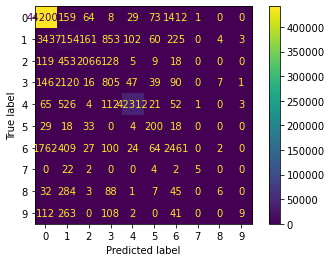

In [73]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()